# 3D Semantic Segmentation

Dataset used is from Beyond the Cranial Vault (BTCV). It can be found [here](https://www.synapse.org/#!Synapse:syn3193805).

To run this notebook:
1. Retrieve saved model checkpoint from [here](https://drive.google.com/drive/folders/1oI8RIMEDl6vOW0-mutafXjPSTByXshNO).
2. Create a directory named `checkpoints` in the root of this project and place models in there.
3. Download data as per instructions on github and place it in a folder named `btcv`.

In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.metrics import DiceMetric

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model.unetr import UNETR

## Plot Dice Score and Loss

### Load Models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
        in_channels=1,
        out_channels=14,
        img_size=(96, 96, 96),
        feature_size=16,
        hidden_size=768,
        num_heads=12,
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    ).to(device)
model.eval()

eval_num = 50

checkpoint = torch.load("../checkpoints/baseline_unetr_btcv_epoch1000.pth")
model.load_state_dict(checkpoint['model'])
baseline_dice_scores = checkpoint['dice']
baseline_epoch_losses = checkpoint["loss"]

checkpoint = torch.load("../checkpoints/pretrain_unetr_btcv_epoch1200.pth")
model.load_state_dict(checkpoint['model'])
pretrained_dice_scores = checkpoint['dice']
pretrained_epoch_losses = checkpoint["loss"]

pretrained_dice_scores = pretrained_dice_scores[:-1]

### Plot

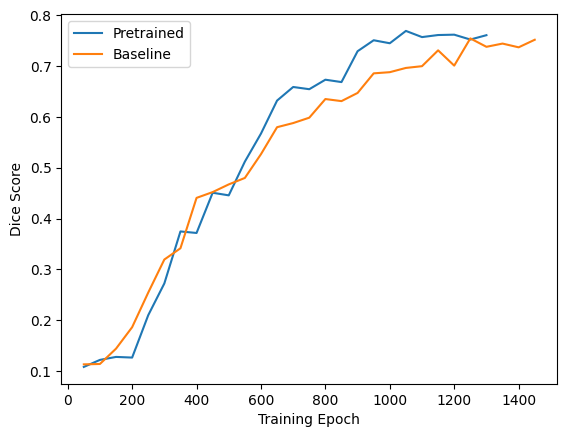

In [10]:
x_labels = [eval_num * (i + 1) for i in range(len(baseline_dice_scores))]
sns.lineplot(x=x_labels, y=baseline_dice_scores, label="Pretrained")
sns.lineplot(x=[eval_num * (i + 1) for i in range(len(pretrained_dice_scores))], y=pretrained_dice_scores, label="Baseline")
plt.xlabel("Training Epoch")
plt.ylabel("Dice Score")
plt.show()

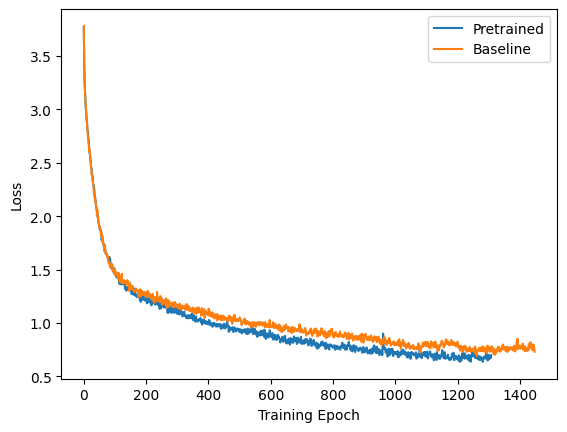

In [12]:
x_labels = [x for x in range(len(baseline_epoch_losses))]
sns.lineplot(x=x_labels, y=baseline_epoch_losses, label="Pretrained")
x_labels = [x for x in range(len(pretrained_epoch_losses))]
sns.lineplot(x=x_labels, y=pretrained_epoch_losses, label="Baseline")
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.show()

## Compare segemented samples

### Load dataset and model

In [14]:
root_dir = ".."
data_dir = "./data/btcv/"
checkpoint_dir = "./checkpoints/"
split_json = "./dataset_0.json"

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    ]
)
datasets = os.path.join(root_dir, data_dir, split_json)
val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)

slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.15s/it]


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
        in_channels=1,
        out_channels=14,
        img_size=(96, 96, 96),
        feature_size=16,
        hidden_size=768,
        num_heads=12,
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    ).to(device)
model.eval()

checkpoint = torch.load("../checkpoints/pretrain_unetr_btcv_epoch1200.pth")
model.load_state_dict(checkpoint['model'])
dice_scores = checkpoint['dice']
epoch_losses = checkpoint["loss"]
eval_num = 50

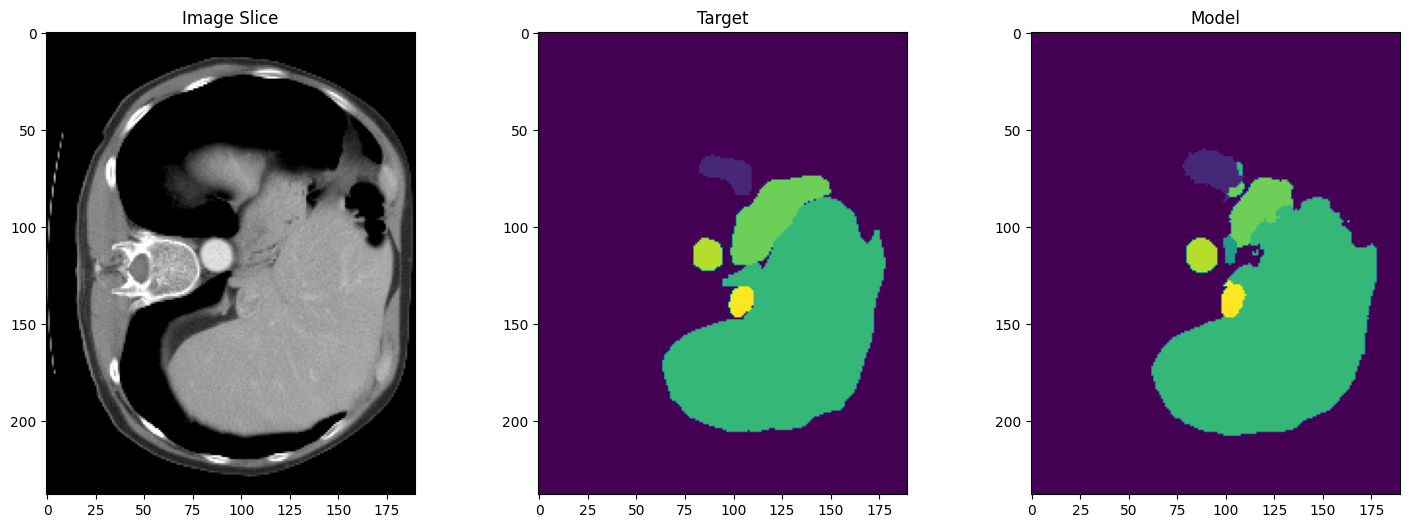

In [17]:
case_num = 2
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Image Slice")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Target")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("Model")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])

    plt.show()